<a href="https://colab.research.google.com/github/sheetalbangalore/ORFE-Senior-Thesis/blob/main/Senior_Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the notebook and importing packages

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Two Data Sources

1. From the "Annual incoming traffic by station of the railway network 2021"

https://data.ratp.fr/explore/dataset/trafic-annuel-entrant-par-station-du-reseau-ferre-2021/information/?dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJ0cmFmaWMiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjNjZjMmE1In1dLCJ4QXhpcyI6InN0YXRpb24iLCJtYXhwb2ludHMiOjIwLCJzb3J0Ijoic2VyaWUxLTEiLCJjb25maWciOnsiZGF0YXNldCI6InRyYWZpYy1hbm51ZWwtZW50cmFudC1wYXItc3RhdGlvbi1kdS1yZXNlYXUtZmVycmUtMjAyMSIsIm9wdGlvbnMiOnt9fX1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D

2. From the RATP website which contains geographical coordinates of the stations

https://github.com/rstudio/gt/blob/master/data-raw/metro.csv

In [2]:
# Read a csv that contains the geographical coordinates of each station

df_geo = pd.read_csv('./gdrive/MyDrive/Senior Thesis/Data and Code/Paris Metro Geographical Coordinates.csv', header=0)
df_geo.drop('connect_rer', axis=1, inplace=True)
df_geo.drop('connect_tramway', axis=1, inplace=True)
df_geo.drop('connect_transilien', axis=1, inplace=True)
df_geo.drop('connect_other', axis=1, inplace=True)
df_geo.drop('passengers', axis=1, inplace=True)
df_geo.drop('min_line', axis=1, inplace=True)

# Fix an incorrect value
bregeut_sabin_index = df_geo[df_geo['Station Name'] == 'BREGUET-SABIN'].index[0]
df_geo.loc[bregeut_sabin_index, 'latitude'] = 48.856

df_geo

,Station Name,lines,latitude,longitude,location
0,ABBESSES,12,48.884849,2.338688,Paris 18th
1,ALESIA,4,48.828333,2.326667,Paris 14th
2,ALEXANDRE DUMAS,2,48.855907,2.394790,"Paris 11th, Paris 20th"
3,ALMA-MARCEAU,9,48.864904,2.300234,"Paris 8th, Paris 16th"
4,ANATOLE FRANCE,3,48.892022,2.285536,Levallois-Perret
...,...,...,...,...,...
299,VILLEJUIF-PAUL VAILLANT-COUTURIER,7,48.795991,2.368248,Villejuif
300,VILLIERS,"2, 3",48.881130,2.314867,"Paris 8th, Paris 17th"
301,VOLONTAIRES,12,48.841343,2.307504,Paris 15th
302,VOLTAIRE,9,48.857803,2.380106,Paris 11th


In [3]:
# Focusing on only Metro data

df_traffic = pd.read_csv('./gdrive/MyDrive/Senior Thesis/Data and Code/2021 Metro Traffic Entering Each Station.csv', header=0)
df_traffic.rename(columns={'Trafic': 'Traffic'}, inplace=True)

# Drop the redundant 'city' column
df_traffic.drop('City', axis=1, inplace=True)

# Find the index of the row with 'FUNICULAIRE'
index_to_drop = df_traffic[df_traffic['Station'] == 'FUNICULAIRE'].index[0]
# Drop the row
df_traffic = df_traffic.drop(index_to_drop)

df_traffic

,ID,Network,Station,Traffic,First Line,Second Line,Third Line,Fourth Line,Fifth Line,Arrondissement for Paris
0,1,Metro,GARE DU NORD,34503097,4,5,NaN,NaN,NaN,10.0
1,2,Metro,SAINT-LAZARE,33128384,3,9,12,13.0,14.0,8.0
2,3,Metro,GARE DE LYON,28640475,1,14,A,NaN,NaN,12.0
3,4,Metro,MONTPARNASSE-BIENVENUE,20407224,4,6,12,13.0,NaN,14.0
4,5,Metro,GARE DE L'EST,15538471,4,5,7,NaN,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...
300,301,Metro,BOLIVAR,367598,7bis,NaN,NaN,NaN,NaN,19.0
301,302,Metro,BUTTES-CHAUMONT,358301,7bis,NaN,NaN,NaN,NaN,19.0
302,303,Metro,PRE-SAINT-GERVAIS,282626,7bis,NaN,NaN,NaN,NaN,19.0
303,304,Metro,PELLEPORT,229524,3bis,NaN,NaN,NaN,NaN,20.0


In [4]:
df1 = pd.merge(df_traffic, df_geo[['Station Name', 'latitude', 'longitude']], left_on='Station', right_on='Station Name', how='left')

# Drop the redundant 'name' column if needed
df1.drop('Station Name', axis=1, inplace=True)
df1

,ID,Network,Station,Traffic,First Line,Second Line,Third Line,Fourth Line,Fifth Line,Arrondissement for Paris,latitude,longitude
0,1,Metro,GARE DU NORD,34503097,4,5,NaN,NaN,NaN,10.0,48.880556,2.355000
1,2,Metro,SAINT-LAZARE,33128384,3,9,12,13.0,14.0,8.0,48.875490,2.326640
2,3,Metro,GARE DE LYON,28640475,1,14,A,NaN,NaN,12.0,48.844722,2.373889
3,4,Metro,MONTPARNASSE-BIENVENUE,20407224,4,6,12,13.0,NaN,14.0,48.843466,2.323072
4,5,Metro,GARE DE L'EST,15538471,4,5,7,NaN,NaN,10.0,48.876111,2.358333
...,...,...,...,...,...,...,...,...,...,...,...,...
299,301,Metro,BOLIVAR,367598,7bis,NaN,NaN,NaN,NaN,19.0,48.880502,2.374922
300,302,Metro,BUTTES-CHAUMONT,358301,7bis,NaN,NaN,NaN,NaN,19.0,48.878500,2.381772
301,303,Metro,PRE-SAINT-GERVAIS,282626,7bis,NaN,NaN,NaN,NaN,19.0,48.880250,2.398910
302,304,Metro,PELLEPORT,229524,3bis,NaN,NaN,NaN,NaN,20.0,48.868671,2.401752


In [5]:
styled_df1 = df1[['Station', 'Traffic']]
# Group by 'Date (Day/Month/Year)' and 'Name of the Station' and calculate the sum of the number of validations
print(styled_df1)

                    Station   Traffic
0              GARE DU NORD  34503097
1              SAINT-LAZARE  33128384
2              GARE DE LYON  28640475
3    MONTPARNASSE-BIENVENUE  20407224
4             GARE DE L'EST  15538471
..                      ...       ...
299                 BOLIVAR    367598
300         BUTTES-CHAUMONT    358301
301       PRE-SAINT-GERVAIS    282626
302               PELLEPORT    229524
303        EGLISE D'AUTEUIL    124941

[304 rows x 2 columns]


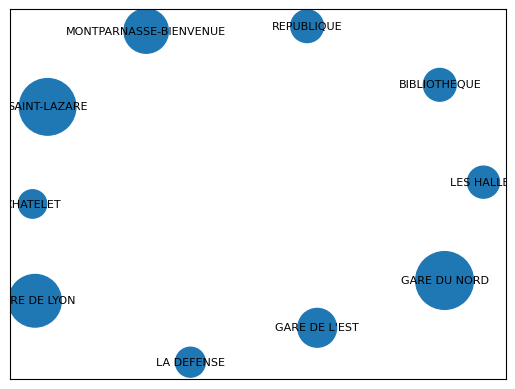

10

In [6]:
# TEST OF ONLY A FEW NODES

# Create a graph object
graph = nx.Graph()
for index, row in styled_df1[0: 10].iterrows():
    graph.add_node(row['Station'], weight=row['Traffic'])

node_sizes = [graph.nodes[node]['weight'] * 0.00005 for node in graph.nodes]

pos = nx.spring_layout(graph)

# Create a dictionary of labels for the nodes where the keys are node names
# and values are the labels you want displayed (e.g., 'Name of the Station').
labels = {node: node for node in graph.nodes()}

# Now you draw the nodes
nodes = nx.draw_networkx_nodes(graph, pos, node_size = node_sizes)
nx.draw_networkx_labels(graph,pos, labels, font_size=8) # draw labels separately

plt.show()  # Display the visualization
graph.number_of_nodes()

# Used in the final report

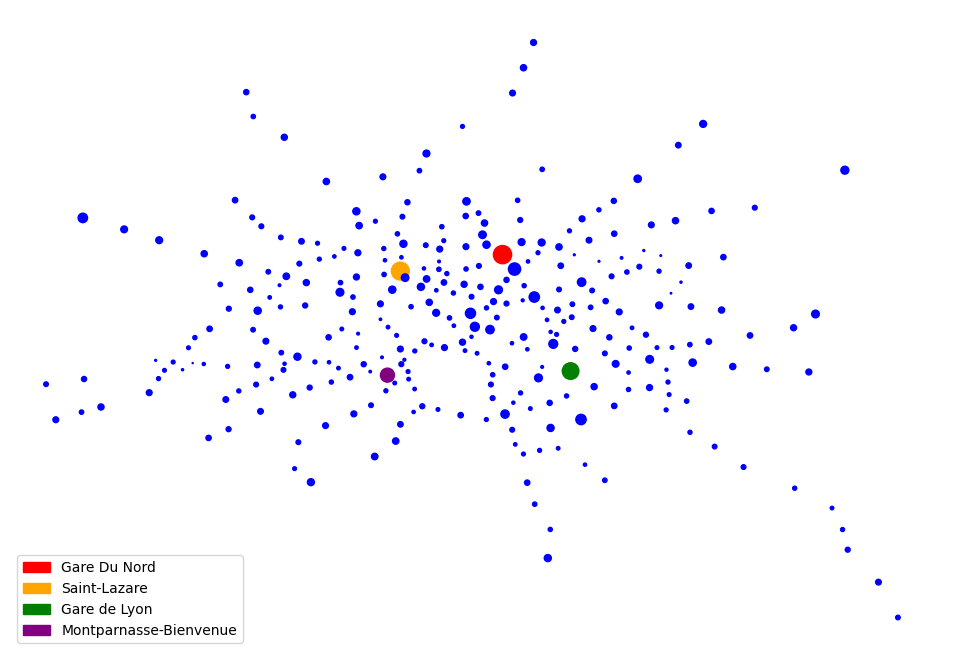

In [7]:
# USED IN FINAL REPORT
# ALL THE METRO STATIONS PLACED GEOGRAPHICALLY WITH COLORED DOTS FOR STATIONS WITH A TRAFFIC OVER 20 MILLION

# Create a graph object
graph1 = nx.Graph()
for index, row in styled_df1.iterrows():
    graph1.add_node(row['Station'], weight=row['Traffic'])

node_sizes = [graph1.nodes[node]['weight'] * 0.000005 for node in graph1.nodes]

# Create a dictionary where keys are station names and values are (latitude, longitude) tuples
pos_geo = {}
for index, row in df1.iterrows():
    pos_geo[row['Station']] = (row['longitude'], row['latitude'])

# Create a dictionary of labels for the nodes where the keys are node names
# and values are the labels you want displayed (e.g., 'Name of the Station').
# labels = {node: node for node in graph1.nodes()}

plt.figure(figsize=(12, 8))  # Adjust the size as needed
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Extract longitude and latitude values from df1 to lists
longitude = df1['longitude'].tolist()
latitude = df1['latitude'].tolist()

plt.xlim([min(longitude) - 0.01, max(longitude) + 0.02])
plt.ylim([min(latitude) - 0.01 , max(latitude) + 0.01])

# Array of colors
node_colors = ['blue'] * len(graph1.nodes())  # Initialize all to blue

# Change the color of 'GARE DU NORD' to red:
node_colors[list(graph1.nodes()).index('GARE DU NORD')] = 'red'
node_colors[list(graph1.nodes()).index('SAINT-LAZARE')] = 'orange'
node_colors[list(graph1.nodes()).index('GARE DE LYON')] = 'green'
node_colors[list(graph1.nodes()).index('MONTPARNASSE-BIENVENUE')] = 'purple'

# Create legend elements (patches)
Gare_du_nord = mpatches.Patch(color='red', label='Gare Du Nord')
Saint_lazare = mpatches.Patch(color='orange', label='Saint-Lazare')
Gare_de_lyon = mpatches.Patch(color='green', label='Gare de Lyon')
Montparnasse_bienvenue = mpatches.Patch(color='purple', label='Montparnasse-Bienvenue')

# Create the legend
plt.legend(handles=[Gare_du_nord, Saint_lazare, Gare_de_lyon, Montparnasse_bienvenue], loc='lower left')

# Draw the graph with the updated node colors:
nx.draw(graph1, pos_geo, node_color=node_colors, node_size=node_sizes)
plt.show()  # Display the visualization

# Used in the final report

In [10]:
# Modifying the data frame, so that the "business" lines are considered as "the .5 version of lines"
df1['First Line'] = df1['First Line'].replace('7bis', 7.5)
df1['First Line'] = df1['First Line'].replace('3bis', 3.5)
df1['Second Line'] = df1['Second Line'].replace('7bis', 7.5)
df1['Second Line'] = df1['Second Line'].replace('3bis', 3.5)
df1['Third Line'] = df1['Third Line'].replace('7bis', 7.5)
df1['Third Line'] = df1['Third Line'].replace('3bis', 3.5)
df1['Fourth Line'] = df1['Fourth Line'].replace('7bis', 7.5)
df1['Fourth Line'] = df1['Fourth Line'].replace('3bis', 3.5)

# Correctly a double count value in the data frame
saint_lazare_index = df1[df1['Station'] == 'SAINT-LAZARE'].index[0]
df1.loc[saint_lazare_index, 'Second Line'] = np.nan
df1.loc[saint_lazare_index, 'Second Line'] = 12
df1.loc[saint_lazare_index, 'Third Line'] = 13
df1.loc[saint_lazare_index, 'Fourth Line'] = 14
df1.loc[saint_lazare_index, 'Fifth Line'] = np.nan
df1

,ID,Network,Station,Traffic,First Line,Second Line,Third Line,Fourth Line,Fifth Line,Arrondissement for Paris,latitude,longitude
0,1,Metro,GARE DU NORD,34503097,4,5,NaN,NaN,NaN,10.0,48.880556,2.355000
1,2,Metro,SAINT-LAZARE,33128384,3,12,13,14.0,NaN,8.0,48.875490,2.326640
2,3,Metro,GARE DE LYON,28640475,1,14,A,NaN,NaN,12.0,48.844722,2.373889
3,4,Metro,MONTPARNASSE-BIENVENUE,20407224,4,6,12,13.0,NaN,14.0,48.843466,2.323072
4,5,Metro,GARE DE L'EST,15538471,4,5,7,NaN,NaN,10.0,48.876111,2.358333
...,...,...,...,...,...,...,...,...,...,...,...,...
299,301,Metro,BOLIVAR,367598,7.5,NaN,NaN,NaN,NaN,19.0,48.880502,2.374922
300,302,Metro,BUTTES-CHAUMONT,358301,7.5,NaN,NaN,NaN,NaN,19.0,48.878500,2.381772
301,303,Metro,PRE-SAINT-GERVAIS,282626,7.5,NaN,NaN,NaN,NaN,19.0,48.880250,2.398910
302,304,Metro,PELLEPORT,229524,3.5,NaN,NaN,NaN,NaN,20.0,48.868671,2.401752


# Used in the final report

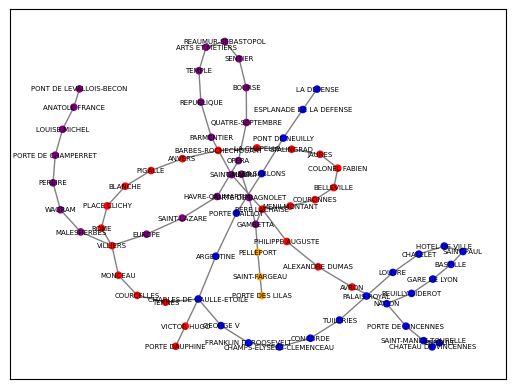

74

In [20]:
# SAMPLE OF THE METRO NETWORK

# Create a graph object
graph_all_lines = nx.Graph()

Line1_Stations_Ordered = ["LA DEFENSE", "ESPLANADE DE LA DEFENSE", "PONT DE NEUILLY", "LES SABLONS", "PORTE MAILLOT",
"ARGENTINE", "CHARLES DE GAULLE-ETOILE", "GEORGE V", "FRANKLIN D. ROOSEVELT", "CHAMPS-ELYSEES-CLEMENCEAU",
"CONCORDE", "TUILERIES", "PALAIS-ROYAL", "LOUVRE", "CHATELET", "HOTEL DE VILLE", "SAINT-PAUL", "BASTILLE",
"GARE DE LYON", "REUILLY-DIDEROT", "NATION", "PORTE DE VINCENNES", "SAINT-MANDE-TOURELLE",
"BERAULT", "CHATEAU DE VINCENNES"]

Line2_Stations_Ordered = ["PORTE DAUPHINE", "VICTOR HUGO", "CHARLES DE GAULLE-ETOILE", "TERNES", "COURCELLES",
"MONCEAU", "VILLIERS", "ROME", "PLACE CLICHY", "BLANCHE", "PIGALLE", "ANVERS", "BARBES-ROCHECHOUART",
"LA CHAPELLE", "STALINGRAD", "JAURES", "COLONEL FABIEN", "BELLEVILLE", "COURONNES", "MENILMONTANT",
"PERE LACHAISE", "PHILIPPE AUGUSTE", "ALEXANDRE DUMAS", "AVRON", "NATION"]

Line3_Stations_Ordered = ["PONT DE LEVALLOIS-BECON", "ANATOLE FRANCE", "LOUISE MICHEL", "PORTE DE CHAMPERRET",
"PEREIRE", "WAGRAM", "MALESHERBES", "VILLIERS", "EUROPE", "SAINT-LAZARE", "HAVRE-CAUMARTIN", "OPERA",
"QUATRE-SEPTEMBRE", "BOURSE", "SENTIER", "REAUMUR-SEBASTOPOL", "ARTS ET METIERS", "TEMPLE", "REPUBLIQUE",
"PARMENTIER", "SAINT-MAUR", "PERE LACHAISE", "GAMBETTA", "PORTE DE BAGNOLET", "GALLIENI"]

Line3bis_Stations_Ordered = ["PORTE DES LILAS", "SAINT-FARGEAU", "PELLEPORT", "GAMBETTA"]

node_sizes = []

for line in {1, 2, 3, 3.5}:
  for index, row in df1.iterrows():
    # Check if the station belongs to the current line
    if row['First Line'] == line  or row['Second Line'] == line or row['Third Line'] == line or row['Fourth Line'] == line or row['Fifth Line'] == line:
        # Add the station as a node to the graph
        graph_all_lines.add_node(row['Station'], weight=row['Traffic'])

for line in {1, 2, 3, 3.5}:
    # Determine which station ordering to use
    if line == 1:
      station_ordering = Line1_Stations_Ordered
    elif line == 2:
      station_ordering = Line2_Stations_Ordered
    elif line == 3:
      station_ordering = Line3_Stations_Ordered
    else:
      station_ordering = Line3bis_Stations_Ordered

    # Add edges for the current line
    for i in range(len(station_ordering) - 1):
      # Get the current and next station in the order
      station1 = station_ordering[i]
      station2 = station_ordering[i + 1]
      # Add an edge between the two stations
      graph_all_lines.add_edge(station1, station2)

# Create a dictionary of labels for the nodes where the keys are node names
# and values are the labels you want displayed (e.g., 'Name of the Station').
labels = {node: node for node in graph_all_lines.nodes()}

# Define node positions (you can customize this)
pos = nx.spring_layout(graph_all_lines)

# Create a dictionary of weights for the nodes where the keys are the station names and the values are the traffic amounts
weight_dict = df1.set_index('Station')['Traffic'].to_dict()

# Now you can draw the nodes and edges
# node_sizes = [graph_all_lines.nodes[node].get('weight', 1) * 0.001 for node in graph_all_lines.nodes]
node_colors = ['blue' if node in Line1_Stations_Ordered else 'red' if node in Line2_Stations_Ordered else 'purple' if node in Line3_Stations_Ordered else 'orange' for node in graph_all_lines.nodes()]
nx.draw_networkx_nodes(graph_all_lines, pos, node_size = 20, node_color = node_colors) # Use the updated node_sizes list
nx.draw_networkx_edges(graph_all_lines, pos, edge_color='gray')
nx.draw_networkx_labels(graph_all_lines,pos, labels, font_size=5) # draw labels separately

plt.show()  # Display the visualization
graph_all_lines.number_of_nodes()

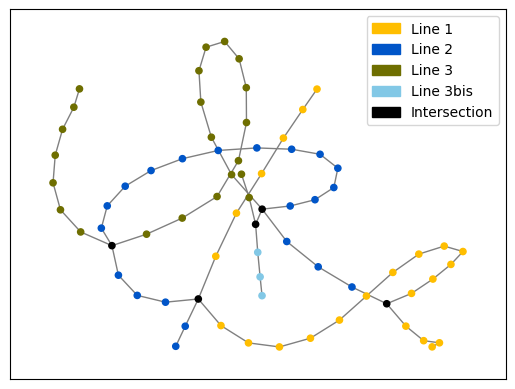

The intersection nodes are:  ['GAMBETTA', 'VILLIERS', 'PERE LACHAISE', 'CHARLES DE GAULLE-ETOILE', 'NATION']


In [21]:
# SAMPLE OF THE METRO NETWORK

node_colors = []
intersection_nodes = []

# Iterate through each node in the graph
for node in graph_all_lines.nodes():
    # Count the number of line lists the node belongs to
    line_count = sum([1 for line_list in [Line1_Stations_Ordered, Line2_Stations_Ordered, Line3_Stations_Ordered, Line3bis_Stations_Ordered] if node in line_list])

    # Assign color based on line count
    if line_count >= 2:
        node_colors.append('black') # Denotes the stations that are on multiple lines (ie intersection points)
        intersection_nodes.append(node)
    else:
        # Assign colors for stations belonging to only one line
        if node in Line1_Stations_Ordered:
          node_colors.append('#ffbe00')
        elif node in Line2_Stations_Ordered:
          node_colors.append('#0055c8')
        elif node in Line3_Stations_Ordered:
          node_colors.append('#6e6e00')
        else:
          node_colors.append('#82c8e6')

# Create legend elements (patches)
line1_patch = mpatches.Patch(color='#ffbe00', label='Line 1')
line2_patch = mpatches.Patch(color='#0055c8', label='Line 2')
line3_patch = mpatches.Patch(color='#6e6e00', label='Line 3')
line3bis_patch = mpatches.Patch(color='#82c8e6', label='Line 3bis')
intersection_patch = mpatches.Patch(color='black', label='Intersection')

# Create the legend
plt.legend(handles=[line1_patch, line2_patch, line3_patch, line3bis_patch, intersection_patch], loc='upper right') # You can adjust 'loc' for legend position

# Now you can draw the nodes with the assigned colors
nx.draw_networkx_nodes(graph_all_lines, pos, node_size=20, node_color=node_colors)
nx.draw_networkx_edges(graph_all_lines, pos, edge_color='gray')

plt.show()
print("The intersection nodes are: ", intersection_nodes)

# Not used in the final report (Code written in order to better understand the data)

In [22]:
# CENTRALITY ANALYSIS FROM THE ARTICLE ON THE ABOVE SAMPLE GRAPH

# Create a dictionary to store line names and their corresponding station orderings
line_stations = {
    "Line 1": Line1_Stations_Ordered,
    "Line 2": Line2_Stations_Ordered,
    "Line 3": Line3_Stations_Ordered,
    "Line 3bis": Line3bis_Stations_Ordered
}

# Iterate through the dictionary and print the number of stations for each line
for line_name, stations in line_stations.items():
    num_stations = len(stations)
    print(f"{line_name}: {num_stations} stations")

distances_from_intersections = {}

for intersection_node in intersection_nodes:
    distances_from_intersections[intersection_node] = nx.shortest_path_length(graph_all_lines, source=intersection_node)

# Print the distances (optional)
for intersection_node, distances in distances_from_intersections.items():
    print(f"Distances from {intersection_node} which is an intersection node:")
    for target_node, distance in distances.items():
        print(f"  To {target_node}: {distance}")

# Print the centrality calculations for the line 1 stops


Line 1: 25 stations
Line 2: 25 stations
Line 3: 25 stations
Line 3bis: 4 stations
Distances from GAMBETTA which is an intersection node:
  To GAMBETTA: 0
  To PERE LACHAISE: 1
  To PORTE DE BAGNOLET: 1
  To PELLEPORT: 1
  To SAINT-MAUR: 2
  To MENILMONTANT: 2
  To PHILIPPE AUGUSTE: 2
  To GALLIENI: 2
  To SAINT-FARGEAU: 2
  To PARMENTIER: 3
  To COURONNES: 3
  To ALEXANDRE DUMAS: 3
  To PORTE DES LILAS: 3
  To REPUBLIQUE: 4
  To BELLEVILLE: 4
  To AVRON: 4
  To TEMPLE: 5
  To COLONEL FABIEN: 5
  To NATION: 5
  To ARTS ET METIERS: 6
  To JAURES: 6
  To REUILLY-DIDEROT: 6
  To PORTE DE VINCENNES: 6
  To REAUMUR-SEBASTOPOL: 7
  To STALINGRAD: 7
  To GARE DE LYON: 7
  To SAINT-MANDE-TOURELLE: 7
  To SENTIER: 8
  To LA CHAPELLE: 8
  To BASTILLE: 8
  To BERAULT: 8
  To BOURSE: 9
  To BARBES-ROCHECHOUART: 9
  To SAINT-PAUL: 9
  To CHATEAU DE VINCENNES: 9
  To QUATRE-SEPTEMBRE: 10
  To ANVERS: 10
  To HOTEL DE VILLE: 10
  To OPERA: 11
  To PIGALLE: 11
  To CHATELET: 11
  To HAVRE-CAUMARTIN: 12

In [24]:
# Create an empty list to store the results
results = []

# Add this function definition before it is called in your code
def find_intersection_nodes_in_shortest_path(graph, source, target, intersection_nodes):
    """
    Finds intersection nodes present in the shortest path between source and target.

    Args:
        graph: The graph object.
        source: The source node.
        target: The target node.
        intersection_nodes: A list of intersection nodes in the graph.

    Returns:
        A list of intersection nodes in the shortest path.
    """
    try:
        shortest_path = nx.shortest_path(graph, source=source, target=target)
        return [node for node in shortest_path if node in intersection_nodes]
    except nx.NetworkXNoPath:
        return []  # Return empty list if no path is found

# Loop through all nodes in the graph
for source_node in graph_all_lines.nodes():
    for target_node in graph_all_lines.nodes():
        # Skip if source and target are the same
        if source_node == target_node:
            continue

        # Find intersection nodes in the shortest path
        intersection_nodes_in_path = find_intersection_nodes_in_shortest_path(
            graph_all_lines, source_node, target_node, intersection_nodes
        )

        # Append the results to the list
        results.append(
            {
                "Source Node": source_node,
                "Target Node": target_node,
                "Intersection Nodes": intersection_nodes_in_path,
            }
        )

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the DataFrame (or save it to a file if desired)
print(results_df)

     Source Node              Target Node                   Intersection Nodes
0       GAMBETTA          PORTE DES LILAS                           [GAMBETTA]
1       GAMBETTA            SAINT-FARGEAU                           [GAMBETTA]
2       GAMBETTA                PELLEPORT                           [GAMBETTA]
3       GAMBETTA  PONT DE LEVALLOIS-BECON  [GAMBETTA, PERE LACHAISE, VILLIERS]
4       GAMBETTA           ANATOLE FRANCE  [GAMBETTA, PERE LACHAISE, VILLIERS]
...          ...                      ...                                  ...
5397       AVRON               BELLEVILLE                      [PERE LACHAISE]
5398       AVRON                COURONNES                      [PERE LACHAISE]
5399       AVRON             MENILMONTANT                      [PERE LACHAISE]
5400       AVRON         PHILIPPE AUGUSTE                                   []
5401       AVRON          ALEXANDRE DUMAS                                   []

[5402 rows x 3 columns]


In [65]:
# Create a dictionary to store line names and their corresponding station orderings
line_stations_1 = {
    "Line 2": Line2_Stations_Ordered,
    "Line 3": Line3_Stations_Ordered,
    "Line 3bis": Line3bis_Stations_Ordered,
    "Line 4": Line4_Stations_Ordered,
    "Line 5": Line5_Stations_Ordered,
    "Line 6": Line6_Stations_Ordered,
    "Line 7": Line7_Stations_Ordered,
    "Line 7bis": Line7bis_Stations_Ordered,
    "Line 8": Line8_Stations_Ordered,
    "Line 9": Line9_Stations_Ordered
}

def calculate_distance_from_intersection_source_line1(graph, source_node, target_nodes, line1_stations):
    """
    Calculates the distance between the intersection node on Line 1 and each target node.

    Args:
        graph: The graph object.
        source_node: The source node (Bastille in this case).
        target_nodes: A list of target nodes.
        line1_stations: A list of stations on Line 1.

    Returns:
        A dictionary where keys are target nodes and values are distances from the intersection node.
    """
    distances = {}
    for target_node in target_nodes:
        # Find shortest path from source to target
        shortest_path = nx.shortest_path(graph, source=source_node, target=target_node)

        # Find intersection node on Line 1 in the shortest path
        line1_intersection = next((node for node in shortest_path if node in line1_stations), None)

        # Find intersection node on the target line in the shortest path
        target_line_intersection = next((node for node in shortest_path if node in target_nodes), None)

        # If both intersections are found, calculate distance between them
        if line1_intersection and target_line_intersection:
            distance = nx.shortest_path_length(graph, source=line1_intersection, target=target_line_intersection)
            distances[target_node] = distance
        else:
            distances[target_node] = -1  # Indicate no intersection found

    return distances

# Create a dictionary to store the results
results = {}
for source_node in Line1_Stations_Ordered:
    results[source_node] = {}  # Initialize an empty dictionary for each source node

for line_name, target_nodes in line_stations_1.items():
  for source_node in Line1_Stations_Ordered:
    distances_from_intersection = calculate_distance_from_intersection_source_line1(graph_all_lines, source_node, target_nodes, Line1_Stations_Ordered)
    # print(f"Distances from {source_node} to {line_name}") # Use line_name here
    # for target_node, distance in distances_from_intersection.items():
      # print(f"  To {target_node}: {distance}")
    # print("The sum of the distances is ", sum(distances_from_intersection.values()))
    results[source_node][line_name] = sum(distances_from_intersection.values())
    # print()

# Create a pandas DataFrame from the results dictionary
df_results = pd.DataFrame(results).T  # Transpose to have Line 1 stations as rows
# Add a column with the sum of all other columns
df_results['Total'] = df_results.sum(axis=1)
df_results

,Line 2,Line 3,Line 3bis,Line 4,Line 5,Line 6,Line 7,Line 7bis,Line 8,Line 9,Total
LA DEFENSE,150,280,84,426,387,168,456,152,398,308,2809
ESPLANADE DE LA DEFENSE,125,255,80,399,365,140,422,144,360,271,2561
PONT DE NEUILLY,100,230,76,372,343,112,388,136,322,234,2313
LES SABLONS,75,205,72,345,321,84,354,128,284,197,2065
PORTE MAILLOT,50,180,68,318,299,56,320,120,246,161,1818
ARGENTINE,25,155,64,291,277,28,286,112,208,124,1570
CHARLES DE GAULLE-ETOILE,0,130,60,264,255,0,252,104,170,87,1322
GEORGE V,153,125,56,257,224,229,170,103,114,73,1504
FRANKLIN D. ROOSEVELT,174,116,52,225,202,226,136,95,76,0,1302
CHAMPS-ELYSEES-CLEMENCEAU,180,107,48,198,180,206,102,87,38,150,1296


In [154]:
source_node = "REUILLY-DIDEROT"
target_nodes = Line2_Stations_Ordered

distances_from_intersection = calculate_distance_from_intersection_source_line1(graph_all_lines, source_node, target_nodes, Line1_Stations_Ordered)
print(distances_from_intersection)
print("The sum of the distances is ", sum(distances_from_intersection.values()))
print()

# TEST AN EXAMPLE

shortest_path = nx.shortest_path(graph_all_lines, source=source_node, target="CHARLES DE GAULLE-ETOILE")
print(shortest_path)
print(len(shortest_path))

{'PORTE DAUPHINE': 13, 'VICTOR HUGO': 13, 'CHARLES DE GAULLE-ETOILE': 13, 'TERNES': 13, 'COURCELLES': 13, 'MONCEAU': 13, 'VILLIERS': 13, 'ROME': 13, 'PLACE CLICHY': 10, 'BLANCHE': 10, 'PIGALLE': 10, 'ANVERS': 10, 'BARBES-ROCHECHOUART': 10, 'LA CHAPELLE': 10, 'STALINGRAD': 10, 'JAURES': 1, 'COLONEL FABIEN': 1, 'BELLEVILLE': 1, 'COURONNES': 1, 'MENILMONTANT': 1, 'PERE LACHAISE': 1, 'PHILIPPE AUGUSTE': 1, 'ALEXANDRE DUMAS': 1, 'AVRON': 1, 'NATION': 1}
The sum of the distances is  184

['REUILLY-DIDEROT', 'GARE DE LYON', 'BASTILLE', 'SAINT-PAUL', 'HOTEL DE VILLE', 'CHATELET', 'LOUVRE', 'PALAIS-ROYAL', 'TUILERIES', 'CONCORDE', 'CHAMPS-ELYSEES-CLEMENCEAU', 'FRANKLIN D. ROOSEVELT', 'GEORGE V', 'CHARLES DE GAULLE-ETOILE']
14


# Used in the final report

                       Source  Total Transfers
0                   ARGENTINE              538
1                    BASTILLE              523
2                     BERAULT              586
3   CHAMPS-ELYSEES-CLEMENCEAU              642
4    CHARLES DE GAULLE-ETOILE              448
5        CHATEAU DE VINCENNES              586
6                    CHATELET              475
7                    CONCORDE              537
8     ESPLANADE DE LA DEFENSE              537
9       FRANKLIN D. ROOSEVELT              611
10               GARE DE LYON              604
11                   GEORGE V              636
12             HOTEL DE VILLE              572
13                 LA DEFENSE              537
14                LES SABLONS              537
15                     LOUVRE              575
16                     NATION              489
17               PALAIS-ROYAL              537
18            PONT DE NEUILLY              537
19         PORTE DE VINCENNES              588
20           

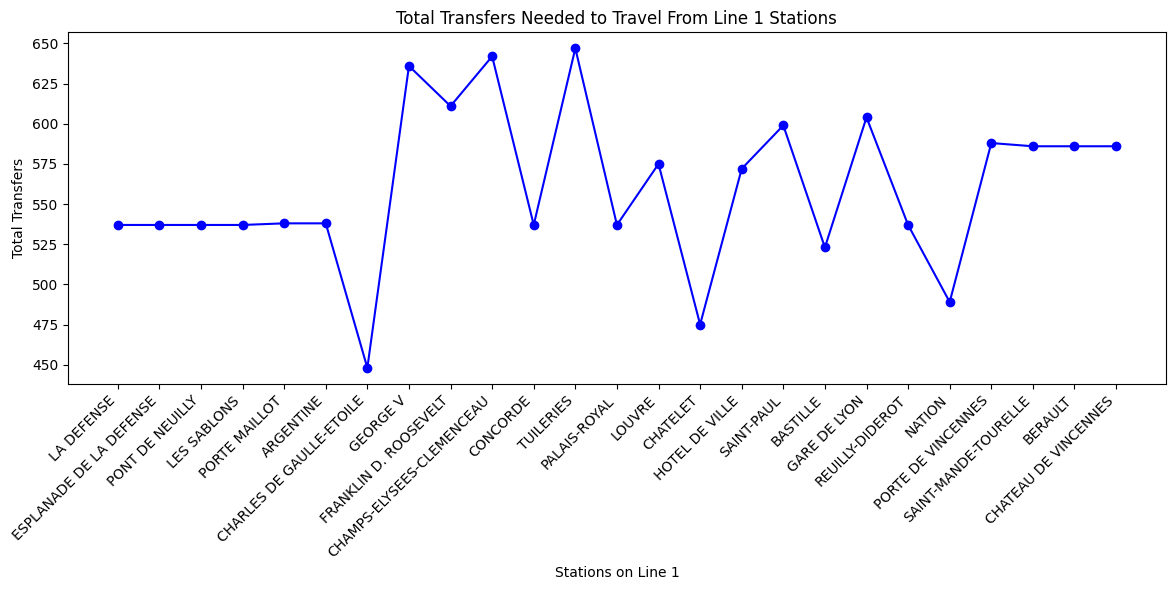

In [109]:
## TABLE

def calculate_transfers(graph, source_stations, target_stations):
    """
    Calculates the number of transfers needed to travel between stations.

    Args:
        graph: The graph representing the network.
        source_stations: A list of source station names.
        target_stations: A list of target station names.

    Returns:
        A dictionary where keys are (source_station, target_station) tuples
        and values are the number of transfers needed.
    """
    transfers_needed = {}
    for source_station in source_stations:
        for target_station in target_stations:
            if source_station == target_station:
                transfers_needed[(source_station, target_station)] = 0  # No transfer needed if source and target are the same
                continue

            # Find shortest path
            shortest_path = nx.shortest_path(graph, source=source_station, target=target_station)

            # Calculate transfers (number of line changes)
            num_transfers = 0
            current_line = None  # Keep track of the current line
            for i in range(len(shortest_path) - 1):
                station1 = shortest_path[i]
                station2 = shortest_path[i + 1]

                # Determine the line connecting station1 and station2
                line = None
                for line_stations in [Line1_Stations_Ordered, Line2_Stations_Ordered, Line3_Stations_Ordered, Line3bis_Stations_Ordered,
                                    Line4_Stations_Ordered, Line5_Stations_Ordered, Line6_Stations_Ordered, Line7_Stations_Ordered,
                                    Line7bis_Stations_Ordered, Line8_Stations_Ordered, Line9_Stations_Ordered]:
                    if station1 in line_stations and station2 in line_stations:
                        line = line_stations # Assign the line if both stations are on it
                        break # Exit the loop if you found a line that contains both stations

                # If line is found and it's different from the current line, increment transfers
                if line and line != current_line:
                    num_transfers += 1
                    current_line = line

            transfers_needed[(source_station, target_station)] = num_transfers

    return transfers_needed

# Calculate transfers from Line 1 stations to all other stations
transfers_from_line1 = calculate_transfers(graph_all_lines, Line1_Stations_Ordered, list(graph_all_lines.nodes()))

# Print the results
#for (source, target), transfers in transfers_from_line1.items():
#    print(f"From {source} to {target}: {transfers} transfers")

# Create a DataFrame from the results
transfers_df = pd.DataFrame(transfers_from_line1.items(), columns=['(Source, Target)', 'Transfers'])
transfers_df[['Source', 'Target']] = pd.DataFrame(transfers_df['(Source, Target)'].tolist(), index= transfers_df.index) # Split the (Source, Target) column into two columns
transfers_df = transfers_df[['Source', 'Target', 'Transfers']] # Reorder the columns

# Group by 'Source' and sum the 'Transfers' column
total_transfers_by_source = transfers_df.groupby('Source')['Transfers'].sum().reset_index()

# Rename the 'Transfers' column to 'Total Transfers' for clarity
total_transfers_by_source.rename(columns={'Transfers': 'Total Transfers'}, inplace=True)

# Print the results
print(total_transfers_by_source)

## GRAPH

# Set 'Source' as the index and reindex to match Line1_Stations_Ordered
total_transfers_by_source = total_transfers_by_source.set_index('Source').reindex(Line1_Stations_Ordered)

# Plotting the data
plt.figure(figsize=(12, 6))

# Create the line plot
plt.plot(total_transfers_by_source.index, total_transfers_by_source['Total Transfers'], marker='o', color='blue')

# Customize the plot
plt.xlabel("Stations on Line 1")
plt.ylabel("Total Transfers")
plt.title("Total Transfers Needed to Travel From Line 1 Stations")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

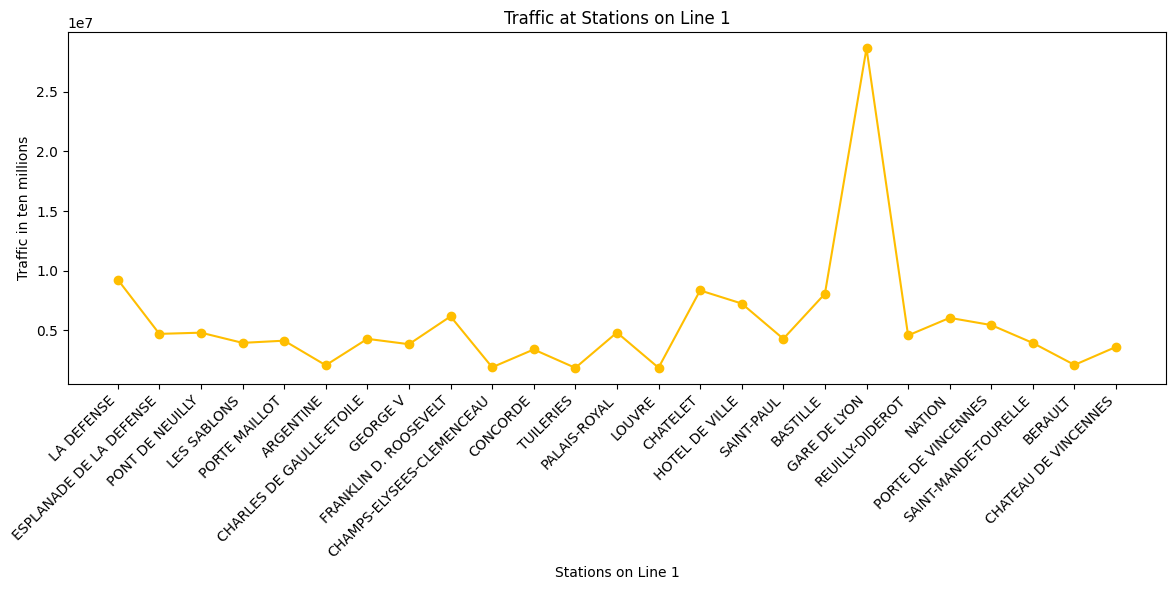

In [155]:
# Create a new DataFrame containing only Line 1 stations and their traffic
line1_traffic_df = df1[df1['Station'].isin(Line1_Stations_Ordered)]

# Set 'Station' as the index and reindex to match Line1_Stations_Ordered
line1_traffic_df = line1_traffic_df.set_index('Station').reindex(Line1_Stations_Ordered)

# Plotting the data
plt.figure(figsize=(12, 6))

# Create the line plot
plt.plot(line1_traffic_df.index, line1_traffic_df['Traffic'], marker='o', color='#ffbe00')

# Customize the plot
plt.xlabel("Stations on Line 1")
plt.ylabel("Traffic in ten millions")
plt.title("Traffic at Stations on Line 1")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

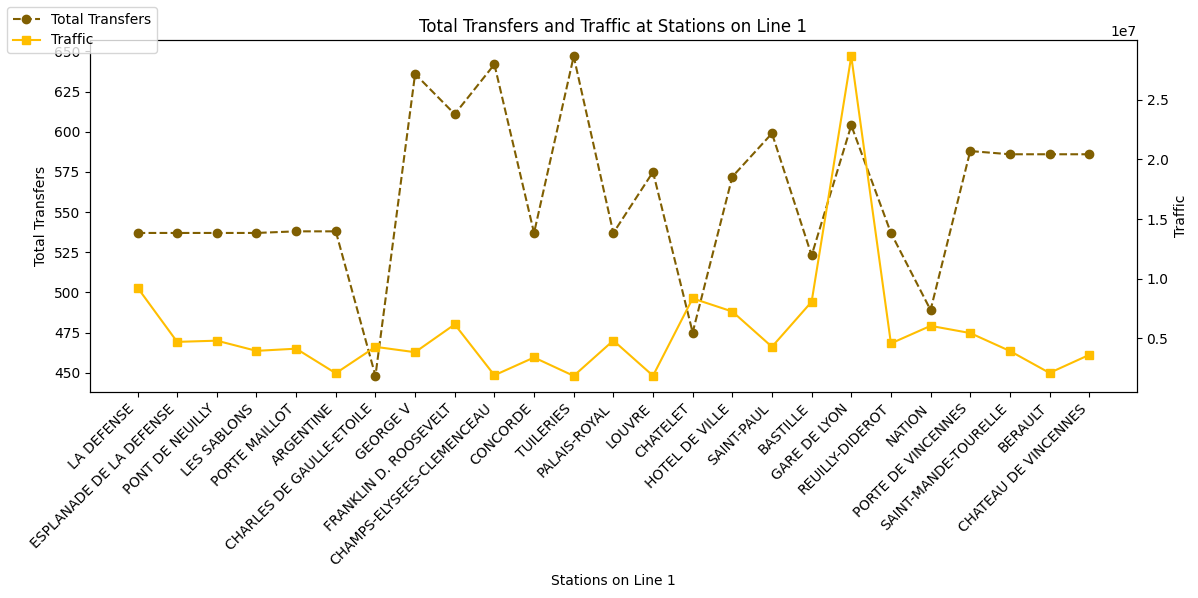

In [137]:
# Filter df1 for Line 1 stations and their traffic
line1_traffic_df = df1[df1['Station'].isin(Line1_Stations_Ordered)]

# Set 'Station' as the index and reindex to match Line1_Stations_Ordered
line1_traffic_df = line1_traffic_df.set_index('Station').reindex(Line1_Stations_Ordered)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Reindex both DataFrames to match Line1_Stations_Ordered before plotting
total_transfers_by_source = total_transfers_by_source.reindex(Line1_Stations_Ordered)
line1_traffic_df = line1_traffic_df.reindex(Line1_Stations_Ordered)

# Plot Total Transfers (left y-axis)
ax1.plot(Line1_Stations_Ordered, total_transfers_by_source['Total Transfers'], marker='o', linestyle='--', color='#805f01', label='Total Transfers')  # Specify x-axis values
ax1.set_xlabel("Stations on Line 1")
ax1.set_ylabel("Total Transfers")
ax1.tick_params('y')

# Create a second y-axis (right) for Traffic
ax2 = ax1.twinx()
ax2.plot(Line1_Stations_Ordered, line1_traffic_df['Traffic'], marker='s', color='#ffbe00', label='Traffic')  # Specify x-axis values
ax2.set_ylabel("Traffic")
ax2.tick_params('y')

ax1.set_xticklabels([])
ax1.set_xticks(range(len(Line1_Stations_Ordered)))
ax1.set_xticklabels(Line1_Stations_Ordered, rotation=45, ha='right')

# Customize the plot
plt.title("Total Transfers and Traffic at Stations on Line 1")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add legend
fig.legend(loc='upper left')  # Adjust location as needed

plt.show()

# Not used in the final report (Code written in order to better understand the data)

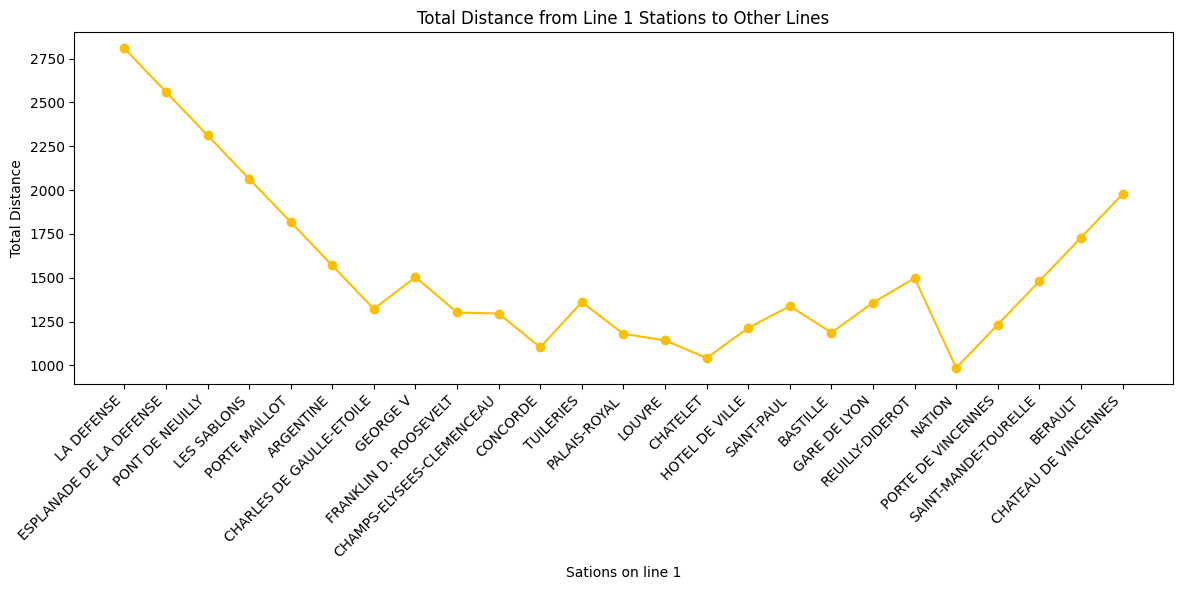

In [63]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(12, 6))

# Extract the "Total Distance" column and station names
total_distances = df_results['Total']
stations = df_results.index

# Create the line plot
plt.plot(stations, total_distances, marker='o', color = '#ffbe00')

# Customize the plot
plt.xlabel("Sations on line 1")
plt.ylabel("Total Distance")
plt.title("Total Distance from Line 1 Stations to Other Lines")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

# Used in the final report

                    Source  Total Transfers
0                   ALESIA              803
1      BARBES-ROCHECHOUART              562
2            CHATEAU D'EAU              688
3            CHATEAU ROUGE              634
4                 CHATELET              475
5                     CITE              619
6        DENFERT-ROCHEREAU              680
7           ETIENNE MARCEL              579
8            GARE DE L'EST              546
9             GARE DU NORD              644
10              LES HALLES              614
11     MAIRIE DE MONTROUGE              803
12   MARCADET-POISSONNIERS              634
13  MONTPARNASSE-BIENVENUE              549
14         MOUTON-DUVERNET              803
15                   ODEON              609
16         PORTE D'ORLEANS              803
17   PORTE DE CLIGNANCOURT              634
18                 RASPAIL              688
19      REAUMUR-SEBASTOPOL              594
20  SAINT-GERMAIN DES PRES              612
21            SAINT-MICHEL      

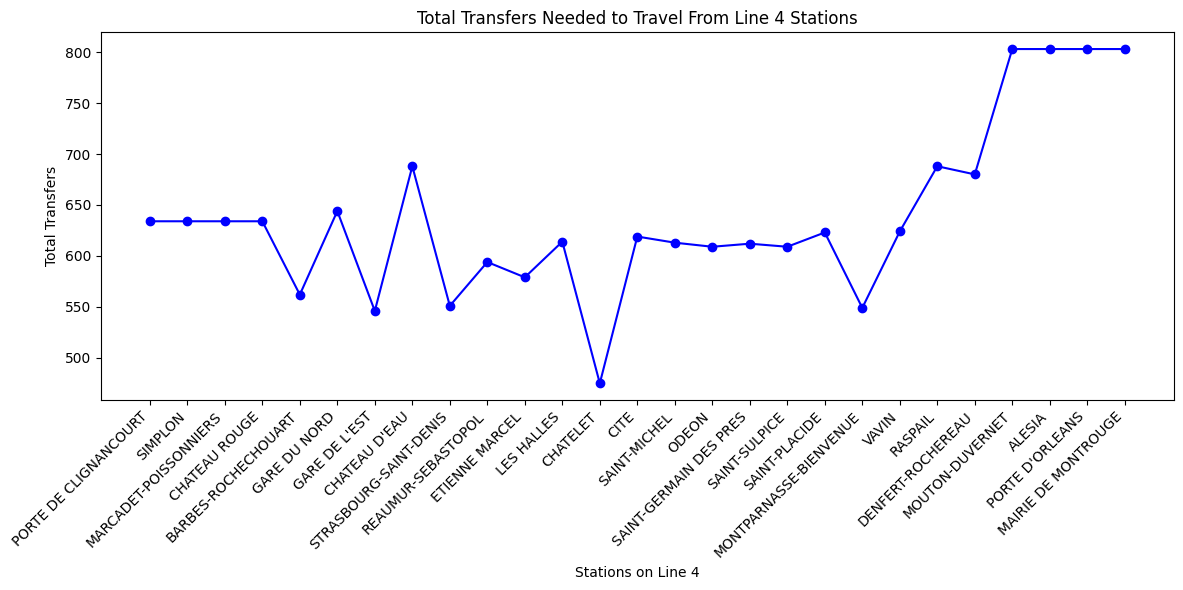

In [147]:
## TABLE

def calculate_transfers(graph, source_stations, target_stations):
    """
    Calculates the number of transfers needed to travel between stations.

    Args:
        graph: The graph representing the network.
        source_stations: A list of source station names.
        target_stations: A list of target station names.

    Returns:
        A dictionary where keys are (source_station, target_station) tuples
        and values are the number of transfers needed.
    """
    transfers_needed = {}
    for source_station in source_stations:
        for target_station in target_stations:
            if source_station == target_station:
                transfers_needed[(source_station, target_station)] = 0  # No transfer needed if source and target are the same
                continue

            # Find shortest path
            shortest_path = nx.shortest_path(graph, source=source_station, target=target_station)

            # Calculate transfers (number of line changes)
            num_transfers = 0
            current_line = None  # Keep track of the current line
            for i in range(len(shortest_path) - 1):
                station1 = shortest_path[i]
                station2 = shortest_path[i + 1]

                # Determine the line connecting station1 and station2
                line = None
                for line_stations in [Line1_Stations_Ordered, Line2_Stations_Ordered, Line3_Stations_Ordered, Line3bis_Stations_Ordered,
                                    Line4_Stations_Ordered, Line5_Stations_Ordered, Line6_Stations_Ordered, Line7_Stations_Ordered,
                                    Line7bis_Stations_Ordered, Line8_Stations_Ordered, Line9_Stations_Ordered]:
                    if station1 in line_stations and station2 in line_stations:
                        line = line_stations # Assign the line if both stations are on it
                        break # Exit the loop if you found a line that contains both stations

                # If line is found and it's different from the current line, increment transfers
                if line and line != current_line:
                    num_transfers += 1
                    current_line = line

            transfers_needed[(source_station, target_station)] = num_transfers

    return transfers_needed

# Calculate transfers from Line 4 stations to all other stations
transfers_from_line4 = calculate_transfers(graph_all_lines, Line4_Stations_Ordered, list(graph_all_lines.nodes()))

# Print the results
#for (source, target), transfers in transfers_from_line1.items():
#    print(f"From {source} to {target}: {transfers} transfers")

# Create a DataFrame from the results
transfers_df = pd.DataFrame(transfers_from_line4.items(), columns=['(Source, Target)', 'Transfers'])
transfers_df[['Source', 'Target']] = pd.DataFrame(transfers_df['(Source, Target)'].tolist(), index= transfers_df.index) # Split the (Source, Target) column into two columns
transfers_df = transfers_df[['Source', 'Target', 'Transfers']] # Reorder the columns

# Group by 'Source' and sum the 'Transfers' column
total_transfers_by_source = transfers_df.groupby('Source')['Transfers'].sum().reset_index()

# Rename the 'Transfers' column to 'Total Transfers' for clarity
total_transfers_by_source.rename(columns={'Transfers': 'Total Transfers'}, inplace=True)

# Print the results
print(total_transfers_by_source)

## GRAPH

# Set 'Source' as the index and reindex to match Line4_Stations_Ordered
total_transfers_by_source = total_transfers_by_source.set_index('Source').reindex(Line4_Stations_Ordered)

# Plotting the data
plt.figure(figsize=(12, 6))

# Create the line plot
plt.plot(total_transfers_by_source.index, total_transfers_by_source['Total Transfers'], marker='o', color='blue')

# Customize the plot
plt.xlabel("Stations on Line 4")
plt.ylabel("Total Transfers")
plt.title("Total Transfers Needed to Travel From Line 4 Stations")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

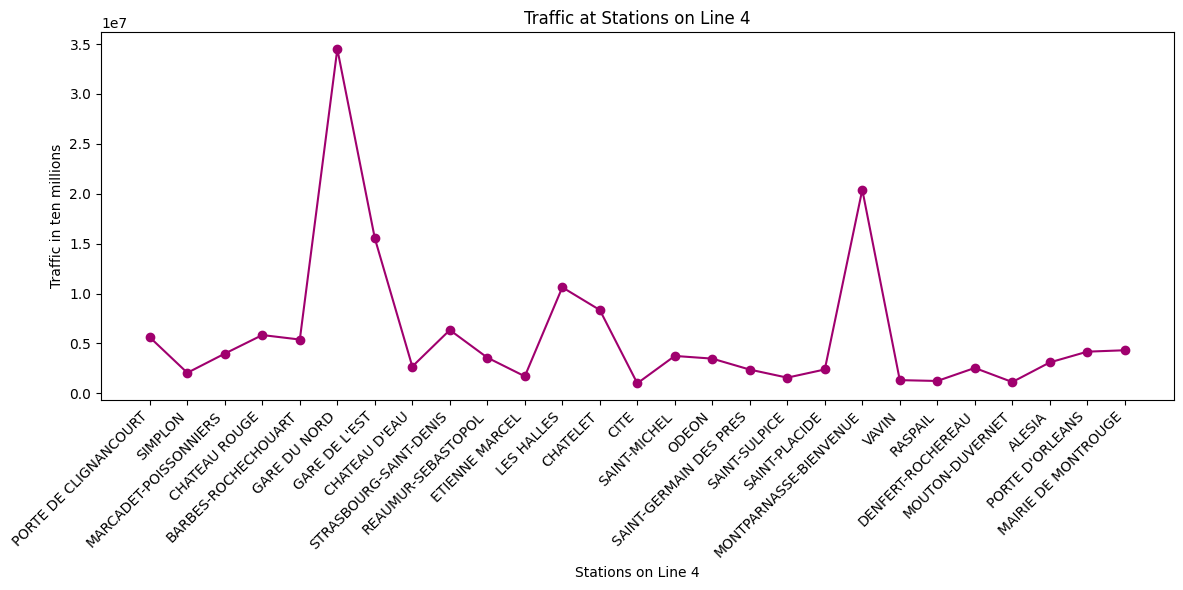

In [156]:
# Create a new DataFrame containing only Line 4 stations and their traffic
line4_traffic_df = df1[df1['Station'].isin(Line4_Stations_Ordered)]

# Set 'Station' as the index and reindex to match Line4_Stations_Ordered
line4_traffic_df = line4_traffic_df.set_index('Station').reindex(Line4_Stations_Ordered)

# Plotting the data
plt.figure(figsize=(12, 6))

# Create the line plot
plt.plot(line4_traffic_df.index, line4_traffic_df['Traffic'], marker='o', color='#a0006e')

# Customize the plot
plt.xlabel("Stations on Line 4")
plt.ylabel("Traffic in ten millions")
plt.title("Traffic at Stations on Line 4")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

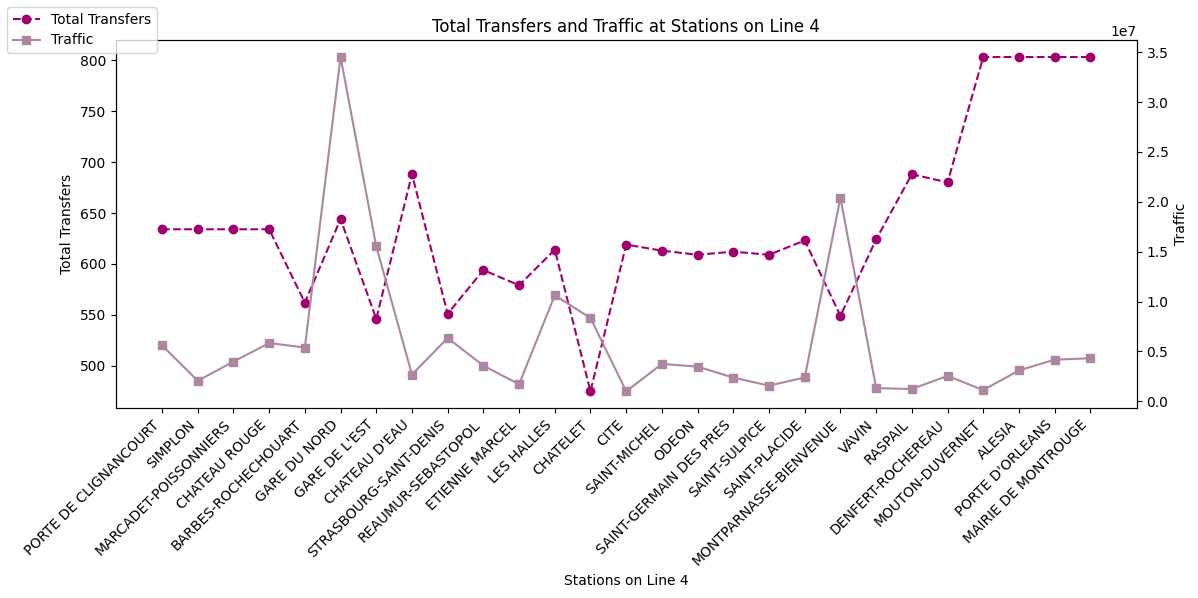

In [153]:
# INCLUDE IN REPORT

# Filter df1 for Line 4 stations and their traffic
line4_traffic_df = df1[df1['Station'].isin(Line4_Stations_Ordered)]

# Set 'Station' as the index and reindex to match Line4_Stations_Ordered
line4_traffic_df = line4_traffic_df.set_index('Station').reindex(Line4_Stations_Ordered)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Reindex both DataFrames to match Line4_Stations_Ordered before plotting
total_transfers_by_source = total_transfers_by_source.reindex(Line4_Stations_Ordered)
line4_traffic_df = line4_traffic_df.reindex(Line4_Stations_Ordered)

# Plot Total Transfers (left y-axis)
ax1.plot(Line4_Stations_Ordered, total_transfers_by_source['Total Transfers'], marker='o', linestyle='--', color='#a0006e', label='Total Transfers')  # Specify x-axis values
ax1.set_xlabel("Stations on Line 4")
ax1.set_ylabel("Total Transfers")
ax1.tick_params('y')

# Create a second y-axis (right) for Traffic
ax2 = ax1.twinx()
ax2.plot(Line4_Stations_Ordered, line4_traffic_df['Traffic'], marker='s', color='#ad86a1', label='Traffic')  # Specify x-axis values
ax2.set_ylabel("Traffic")
ax2.tick_params('y')

ax1.set_xticklabels([])
ax1.set_xticks(range(len(Line4_Stations_Ordered)))
ax1.set_xticklabels(Line4_Stations_Ordered, rotation=45, ha='right')

# Customize the plot
plt.title("Total Transfers and Traffic at Stations on Line 4")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add legend
fig.legend(loc='upper left')  # Adjust location as needed

plt.show()

# Not used in the final report (Code written in order to better understand the data)

In [139]:
# Create a dictionary to store line names and their corresponding station orderings
line_stations_4 = {
    "Line 1": Line1_Stations_Ordered,
    "Line 2": Line2_Stations_Ordered,
    "Line 3": Line3_Stations_Ordered,
    "Line 3bis": Line3bis_Stations_Ordered,
    "Line 5": Line5_Stations_Ordered,
    "Line 6": Line6_Stations_Ordered,
    "Line 7": Line7_Stations_Ordered,
    "Line 7bis": Line7bis_Stations_Ordered,
    "Line 8": Line8_Stations_Ordered,
    "Line 9": Line9_Stations_Ordered
}

def calculate_distance_from_intersection_source_line4(graph, source_node, target_nodes, line4_stations):
    """
    Calculates the distance between the intersection node on Line 4 and each target node.

    Args:
        graph: The graph object.
        source_node: The source node (Bastille in this case).
        target_nodes: A list of target nodes.
        line1_stations: A list of stations on Line 4.

    Returns:
        A dictionary where keys are target nodes and values are distances from the intersection node.
    """
    distances = {}
    for target_node in target_nodes:
        # Find shortest path from source to target
        shortest_path = nx.shortest_path(graph, source=source_node, target=target_node)

        # Find intersection node on Line 4 in the shortest path
        line4_intersection = next((node for node in shortest_path if node in line4_stations), None)

        # Find intersection node on the target line in the shortest path
        target_line_intersection = next((node for node in shortest_path if node in target_nodes), None)

        # If both intersections are found, calculate distance between them
        if line4_intersection and target_line_intersection:
            distance = nx.shortest_path_length(graph, source=line4_intersection, target=target_line_intersection)
            distances[target_node] = distance
        else:
            distances[target_node] = -1  # Indicate no intersection found

    return distances

# Create a dictionary to store the results
results_4 = {}
for source_node in Line4_Stations_Ordered:
    results_4[source_node] = {}  # Initialize an empty dictionary for each source node

for line_name, target_nodes in line_stations_4.items():
  for source_node in Line4_Stations_Ordered:
    distances_from_intersection = calculate_distance_from_intersection_source_line4(graph_all_lines, source_node, target_nodes, Line4_Stations_Ordered)
    # print(f"Distances from {source_node} to {line_name}") # Use line_name here
    # for target_node, distance in distances_from_intersection.items():
      # print(f"  To {target_node}: {distance}")
    # print("The sum of the distances is ", sum(distances_from_intersection.values()))
    results_4[source_node][line_name] = sum(distances_from_intersection.values())
    # print()

# Create a pandas DataFrame from the results dictionary
df_results_4 = pd.DataFrame(results_4).T  # Transpose to have Line 1 stations as rows
# Add a column with the sum of all other columns
df_results_4['Total'] = df_results_4.sum(axis=1)
df_results_4

,Line 1,Line 2,Line 3,Line 3bis,Line 5,Line 6,Line 7,Line 7bis,Line 8,Line 9,Total
PORTE DE CLIGNANCOURT,331,100,231,48,119,453,204,56,340,420,2302
SIMPLON,306,75,206,44,97,425,170,48,302,383,2056
MARCADET-POISSONNIERS,281,50,181,40,75,397,136,40,264,346,1810
CHATEAU ROUGE,256,25,156,36,53,369,102,32,226,309,1564
BARBES-ROCHECHOUART,231,0,131,32,31,341,68,24,188,272,1318
GARE DU NORD,219,53,125,28,0,330,34,16,150,151,1106
GARE DE L'EST,173,98,117,24,0,305,0,23,112,114,966
CHATEAU D'EAU,165,122,118,24,32,302,158,31,38,45,1035
STRASBOURG-SAINT-DENIS,140,139,61,20,33,274,156,39,0,0,862
REAUMUR-SEBASTOPOL,133,160,0,24,79,276,106,47,164,162,1151


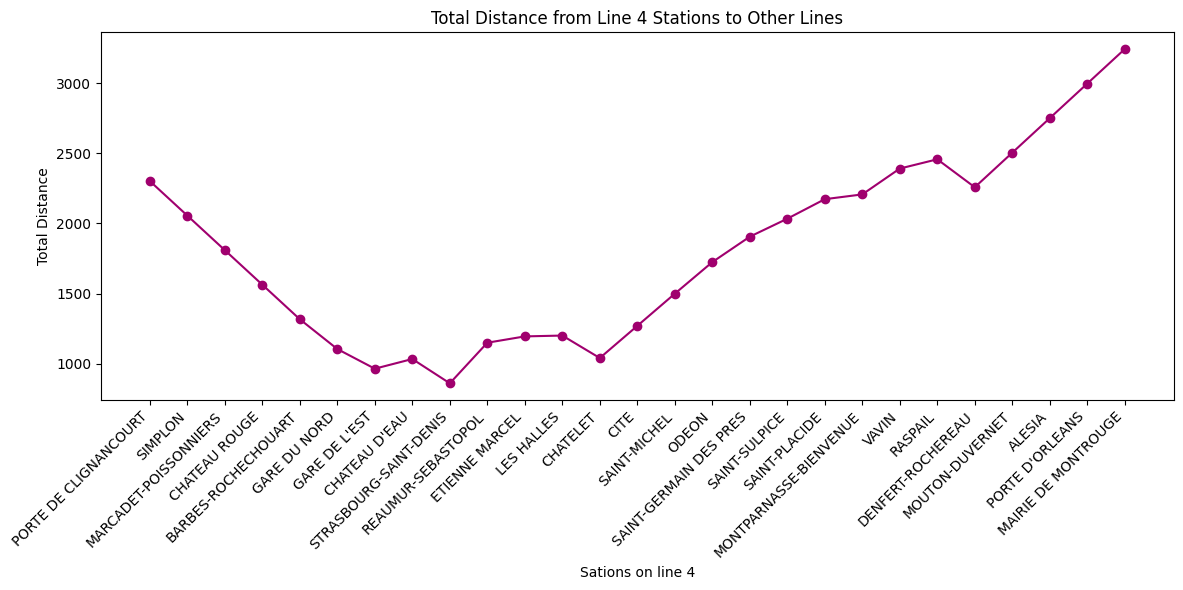

In [144]:
# Plotting the data
plt.figure(figsize=(12, 6))

# Extract the "Total Distance" column and station names
total_distances = df_results_4['Total']
stations = df_results_4.index

# Create the line plot
plt.plot(stations, total_distances, marker='o', color = '#a0006e')

# Customize the plot
plt.xlabel("Sations on line 4")
plt.ylabel("Total Distance")
plt.title("Total Distance from Line 4 Stations to Other Lines")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

# Used in the final report

In [102]:
## TRADITIONAL CENTRALITIES

## Degree Centrality
degree = nx.degree_centrality(graph_all_lines)

# Get the top 5 nodes sorted by centrality score in descending order
top_5_centrality = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes with largest degree centrality:")
for node, score in top_5_centrality:
    print(f"- {node}: {score:.5f}")

## Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(graph_all_lines)

# Sort nodes by betweenness centrality in descending order
sorted_nodes = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)

# Get the top 5 nodes sorted by centrality score in descending order
print("Top 5 nodes with largest betweenness centrality:")
for node, centrality in sorted_nodes[:5]:
    print(f"- {node}: {centrality:.5f}")

## Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(graph_all_lines)

# Sort nodes by closeness centrality in descending order
sorted_nodes_closeness = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)

# Print the top five nodes with largest closeness centrality
print("Top 5 nodes with largest closeness centrality:")
for node, centrality in sorted_nodes_closeness[:5]:
    print(f"- {node}: {centrality:.5f}")

Top 5 nodes with largest degree centrality:
- REPUBLIQUE: 0.02667
- NATION: 0.02667
- CHATELET: 0.02667
- BASTILLE: 0.02667
- OPERA: 0.02667
Top 5 nodes with largest betweenness centrality:
- BASTILLE: 0.26964
- CHATELET: 0.26393
- CONCORDE: 0.23248
- REPUBLIQUE: 0.20719
- GARE DE L'EST: 0.20539
Top 5 nodes with largest closeness centrality:
- CHATELET: 0.11480
- STRASBOURG-SAINT-DENIS: 0.11233
- REPUBLIQUE: 0.11172
- LOUVRE: 0.11057
- PONT NEUF: 0.11057


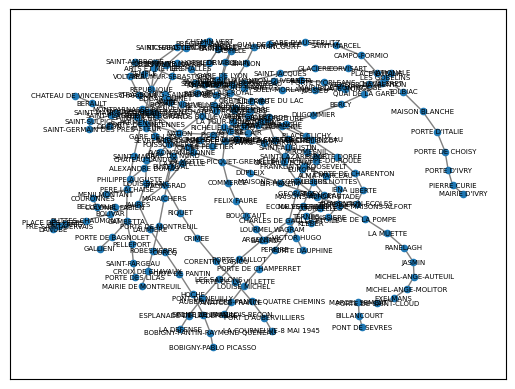

226

In [87]:
# KEEP MODIFYING: ADD ALL LINES
# ISSUES: I COULDN'T FIGURE OUT HOW TO PROPERLY ADD LINES THAT WERE COMPLICATED (bottom part of line7 wasn't added, ...)

# Create a graph object
graph_all_lines = nx.Graph()

Line1_Stations_Ordered = ["LA DEFENSE", "ESPLANADE DE LA DEFENSE", "PONT DE NEUILLY", "LES SABLONS", "PORTE MAILLOT",
"ARGENTINE", "CHARLES DE GAULLE-ETOILE", "GEORGE V", "FRANKLIN D. ROOSEVELT", "CHAMPS-ELYSEES-CLEMENCEAU",
"CONCORDE", "TUILERIES", "PALAIS-ROYAL", "LOUVRE", "CHATELET", "HOTEL DE VILLE", "SAINT-PAUL", "BASTILLE",
"GARE DE LYON", "REUILLY-DIDEROT", "NATION", "PORTE DE VINCENNES", "SAINT-MANDE-TOURELLE",
"BERAULT", "CHATEAU DE VINCENNES"]

Line2_Stations_Ordered = ["PORTE DAUPHINE", "VICTOR HUGO", "CHARLES DE GAULLE-ETOILE", "TERNES", "COURCELLES",
"MONCEAU", "VILLIERS", "ROME", "PLACE CLICHY", "BLANCHE", "PIGALLE", "ANVERS", "BARBES-ROCHECHOUART",
"LA CHAPELLE", "STALINGRAD", "JAURES", "COLONEL FABIEN", "BELLEVILLE", "COURONNES", "MENILMONTANT",
"PERE LACHAISE", "PHILIPPE AUGUSTE", "ALEXANDRE DUMAS", "AVRON", "NATION"]

Line3_Stations_Ordered = ["PONT DE LEVALLOIS-BECON", "ANATOLE FRANCE", "LOUISE MICHEL", "PORTE DE CHAMPERRET",
"PEREIRE", "WAGRAM", "MALESHERBES", "VILLIERS", "EUROPE", "SAINT-LAZARE", "HAVRE-CAUMARTIN", "OPERA",
"QUATRE-SEPTEMBRE", "BOURSE", "SENTIER", "REAUMUR-SEBASTOPOL", "ARTS ET METIERS", "TEMPLE", "REPUBLIQUE",
"PARMENTIER", "SAINT-MAUR", "PERE LACHAISE", "GAMBETTA", "PORTE DE BAGNOLET", "GALLIENI"]

Line3bis_Stations_Ordered = ["PORTE DES LILAS", "SAINT-FARGEAU", "PELLEPORT", "GAMBETTA"]

Line4_Stations_Ordered = ["PORTE DE CLIGNANCOURT", "SIMPLON", "MARCADET-POISSONNIERS", "CHATEAU ROUGE",
"BARBES-ROCHECHOUART", "GARE DU NORD", "GARE DE L'EST", "CHATEAU D'EAU", "STRASBOURG-SAINT-DENIS",
"REAUMUR-SEBASTOPOL", "ETIENNE MARCEL", "LES HALLES", "CHATELET", "CITE", "SAINT-MICHEL", "ODEON",
"SAINT-GERMAIN DES PRES", "SAINT-SULPICE", "SAINT-PLACIDE", "MONTPARNASSE-BIENVENUE", "VAVIN", "RASPAIL",
"DENFERT-ROCHEREAU", "MOUTON-DUVERNET", "ALESIA", "PORTE D'ORLEANS", "MAIRIE DE MONTROUGE"]

Line5_Stations_Ordered = ["BOBIGNY-PABLO PICASSO", "BOBIGNY-PANTIN-RAYMOND QUENEAU", "EGLISE DE PANTIN", "HOCHE",
"PORTE DE PANTIN", "OURCQ", "LAUMIERE", "JAURES", "STALINGRAD", "GARE DU NORD", "GARE DE L'EST", "JACQUES BONSERGENT",
"REPUBLIQUE", "OBERKAMPF", "RICHARD LENOIR", "BREGUET-SABIN", "BASTILLE", "QUAI DE LA RAPEE", "GARE D'AUSTERLITZ",
"SAINT-MARCEL", "CAMPO-FORMIO", "PLACE D'ITALIE"]

Line6_Stations_Ordered = ["CHARLES DE GAULLE-ETOILE", "KLEBER", "BOISSIERE", "TROCADERO", "PASSY", "BIR-HAKEIM",
"DUPLEIX", "LA MOTTE-PICQUET-GRENELLE", "CAMBRONNE", "SEVRES-LECOURBE", "PASTEUR", "MONTPARNASSE-BIENVENUE",
"EDGAR QUINET", "RASPAIL", "DENFERT-ROCHEREAU", "SAINT-JACQUES", "GLACIERE", "CORVISART", "PLACE D'ITALIE",
"NATIONALE", "CHEVALERET", "QUAI DE LA GARE", "BERCY", "DUGOMMIER", "DAUMESNIL", "BEL AIR", "PICPUS", "NATION"]

Line7_Stations_Ordered = ["LA COURNEUVE-8 MAI 1945", "FORT D'AUBERVILLIERS", "AUBERVILLIERS-PANTIN-QUATRE CHEMINS",
"PORTE DE LA VILLETTE", "CORENTIN CARIOU", "CRIMEE", "RIQUET", "STALINGRAD", "LOUIS BLANC", "CHATEAU-LANDON",
"GARE DE L'EST", "POISSONNIERE", "CADET", "LE PELETIER", "CHAUSSEE D'ANTIN-LA FAYETTE", "OPERA", "PYRAMIDES",
"PALAIS-ROYAL", "PONT NEUF", "CHATELET", "PONT MARIE", "SULLY-MORLAND", "JUSSIEU", "PLACE MONGE",
"CENSIER-DAUBENTON", "LES GOBELINS", "PLACE D'ITALIE", "TOLBIAC", "MAISON BLANCHE", "PORTE D'ITALIE", "PORTE DE CHOISY",
"PORTE D'IVRY", "PIERRE CURIE", "MAIRIE D'IVRY"]

Line7bis_Stations_Ordered = ["LOUIS BLANC", "JAURES", "BOLIVAR", "BUTTES-CHAUMONT", "BOTZARIS", "PLACE DES FETES",
"PRE-SAINT-GERVAIS", "DANUBE", "BOTZARIS"]

Line8_Stations_Ordered = ["BALARD", "LOURMEL", "BOUCICAUT", "FELIX FAURE", "COMMERCE", "LA MOTTE-PICQUET-GRENELLE",
"ECOLE MILITAIRE", "LA TOUR-MAUBOURG", "INVALIDES", "CONCORDE", "MADELEINE", "OPERA", "RICHELIEU-DROUOT",
"GRANDS BOULEVARDS", "BONNE NOUVELLE", "STRASBOURG-SAINT-DENIS", "REPUBLIQUE", "FILLES DU CALVAIRE",
"SAINT-SEBASTIEN-FROISSART", "CHEMIN VERT", "BASTILLE", "LEDRU-ROLLIN", "FAIDHERBE-CHALIGNY", "REUILLY-DIDEROT",
"MONTGALLET", "DAUMESNIL", "MICHEL BIZOT", "PORTE DOREE", "PORTE DE CHARENTON", "LIBERTE", "CHARENTON-ECOLES",
"ECOLE VETERINAIRE DE MAISONS-ALFORT", "MAISONS-ALFORT-STADE", "MAISONS-ALFORT-LES JUILLIOTTES",
"CRETEIL-L'ECHAT", "CRETEIL-UNIVERSITE", "CRETEIL-PREFECTURE", "CRETEIL-POINTE DU LAC"]

Line9_Stations_Ordered = ["PONT DE SEVRES", "BILLANCOURT", "MARCEL SEMBAT", "PORTE DE SAINT-CLOUD", "EXELMANS",
"MICHEL-ANGE-MOLITOR", "MICHEL-ANGE-AUTEUIL", "JASMIN", "RANELAGH", "LA MUETTE", "RUE DE LA POMPE", "TROCADERO",
"IENA", "ALMA-MARCEAU", "FRANKLIN D. ROOSEVELT", "SAINT-PHILIPPE-DU-ROULE", "MIROMESNIL", "SAINT-AUGUSTIN",
"HAVRE-CAUMARTIN", "CHAUSSEE D'ANTIN-LA FAYETTE", "RICHELIEU-DROUOT", "GRANDS BOULEVARDS", "BONNE NOUVELLE",
"STRASBOURG-SAINT-DENIS", "REPUBLIQUE", "OBERKAMPF", "SAINT-AMBROISE", "VOLTAIRE", "CHARONNE",
"RUE DES BOULETS", "NATION", "BUZENVAL", "MARAICHERS", "PORTE DE MONTREUIL", "ROBESPIERRE", "CROIX DE CHAVAUX",
"MAIRIE DE MONTREUIL"]

for line in {1, 2, 3, 3.5, 4, 5, 6, 7, 7.5, 8, 9}:
  for index, row in df1.iterrows():
    # Check if the station belongs to the current line
    if row['First Line'] == line  or row['Second Line'] == line or row['Third Line'] == line or row['Fourth Line'] == line or row['Fifth Line'] == line:
        # Add the station as a node to the graph
        graph_all_lines.add_node(row['Station'], weight=row['Traffic'])

for line in {1, 2, 3, 3.5, 4, 5, 6, 7, 7.5, 8, 9}:
    # Determine which station ordering to use
    if line == 1:
      station_ordering = Line1_Stations_Ordered
    elif line == 2:
      station_ordering = Line2_Stations_Ordered
    elif line == 3:
      station_ordering = Line3_Stations_Ordered
    elif line == 3.5:
      station_ordering = Line3bis_Stations_Ordered
    elif line == 4:
      station_ordering = Line4_Stations_Ordered
    elif line == 5:
      station_ordering = Line5_Stations_Ordered
    elif line == 6:
      station_ordering = Line6_Stations_Ordered
    elif line == 7:
      station_ordering = Line7_Stations_Ordered
    elif line == 7.5:
      station_ordering = Line7bis_Stations_Ordered
    elif line == 8:
      station_ordering = Line8_Stations_Ordered
    else:
      station_ordering = Line9_Stations_Ordered

    # Add edges for the current line
    for i in range(len(station_ordering) - 1):
      # Get the current and next station in the order
      station1 = station_ordering[i]
      station2 = station_ordering[i + 1]
      # Add an edge between the two stations
      graph_all_lines.add_edge(station1, station2)

# Create a dictionary of labels for the nodes where the keys are node names
# and values are the labels you want displayed (e.g., 'Name of the Station').
labels = {node: node for node in graph_all_lines.nodes()}

# Define node positions (you can customize this)
pos = nx.spring_layout(graph_all_lines)

# Create a dictionary of weights for the nodes where the keys are the station names and the values are the traffic amounts
weight_dict = df1.set_index('Station')['Traffic'].to_dict()

# Now you can draw the nodes and edges
# node_sizes = [graph_all_lines.nodes[node].get('weight', 1) * 0.001 for node in graph_all_lines.nodes]
nx.draw_networkx_nodes(graph_all_lines, pos, node_size = 20) # Use the updated node_sizes list
nx.draw_networkx_edges(graph_all_lines, pos, edge_color='gray')
nx.draw_networkx_labels(graph_all_lines,pos, labels, font_size=5) # draw labels separately

plt.show()  # Display the visualization
graph_all_lines.number_of_nodes()

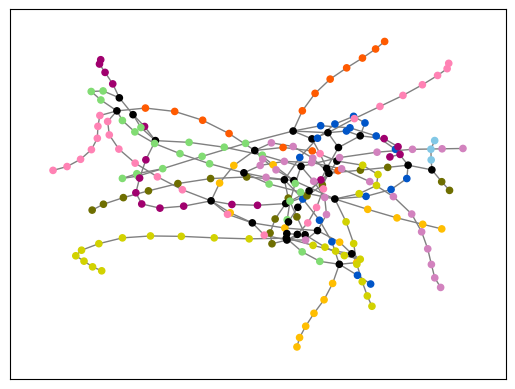

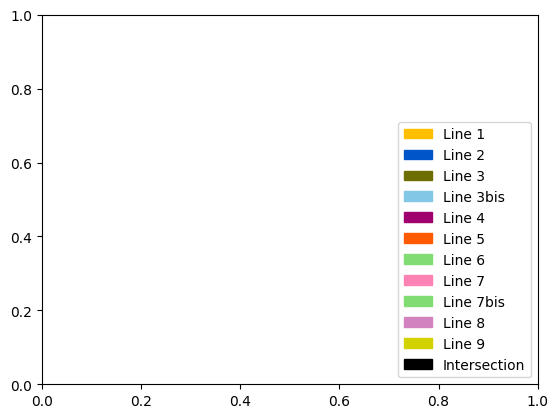

In [33]:
# KEEP MODIFYING: ADD ALL LINES
# ISSUES: I COULDN'T FIGURE OUT HOW TO PROPERLY ADD LINES THAT WERE COMPLICATED (bottom part of line7 wasn't added, ...)

# Create a list to store node colors
node_colors = []

# Iterate through each node in the graph
for node in graph_all_lines.nodes():
    # Count the number of line lists the node belongs to
    line_count = sum([1 for line_list in [Line1_Stations_Ordered, Line2_Stations_Ordered, Line3_Stations_Ordered, Line3bis_Stations_Ordered,
                                          Line4_Stations_Ordered, Line5_Stations_Ordered, Line6_Stations_Ordered, Line7_Stations_Ordered,
                                          Line7bis_Stations_Ordered, Line8_Stations_Ordered, Line9_Stations_Ordered]
                      if node in line_list])

    # Assign color based on line count
    if line_count >= 2:
        node_colors.append('black') # Denotes the stations that are on multiple lines (ie intersection points)
    else:
        # Assign colors for stations belonging to only one line
        if node in Line1_Stations_Ordered:
          node_colors.append('#ffbe00')
        elif node in Line2_Stations_Ordered:
          node_colors.append('#0055c8')
        elif node in Line3_Stations_Ordered:
          node_colors.append('#6e6e00')
        elif node in Line3bis_Stations_Ordered:
          node_colors.append('#82c8e6')
        elif node in Line4_Stations_Ordered:
          node_colors.append('#a0006e')
        elif node in Line5_Stations_Ordered:
          node_colors.append('#ff5a00')
        elif node in Line6_Stations_Ordered:
          node_colors.append('#81dc73')
        elif node in Line7_Stations_Ordered:
          node_colors.append('#ff82b4')
        elif node in Line7bis_Stations_Ordered:
          node_colors.append('#81dc73')
        elif node in Line8_Stations_Ordered:
          node_colors.append('#d282be')
        else:
          node_colors.append('#d2d200')

# Create legend elements (patches)
line1_patch = mpatches.Patch(color='#ffbe00', label='Line 1')
line2_patch = mpatches.Patch(color='#0055c8', label='Line 2')
line3_patch = mpatches.Patch(color='#6e6e00', label='Line 3')
line3bis_patch = mpatches.Patch(color='#82c8e6', label='Line 3bis')
line4_patch = mpatches.Patch(color='#a0006e', label='Line 4')
line5_patch = mpatches.Patch(color='#ff5a00', label='Line 5')
line6_patch = mpatches.Patch(color='#81dc73', label='Line 6')
line7_patch = mpatches.Patch(color='#ff82b4', label='Line 7')
line7bis_patch = mpatches.Patch(color='#81dc73', label='Line 7bis')
line8_patch = mpatches.Patch(color='#d282be', label='Line 8')
line9_patch = mpatches.Patch(color='#d2d200', label='Line 9')
intersection_patch = mpatches.Patch(color='black', label='Intersection')

# Now you can draw the nodes with the assigned colors
nx.draw_networkx_nodes(graph_all_lines, pos, node_size=20, node_color=node_colors)
nx.draw_networkx_edges(graph_all_lines, pos, edge_color='gray')

plt.show()

# Create the legend
plt.legend(handles=[line1_patch, line2_patch, line3_patch, line3bis_patch, line4_patch, line5_patch, line6_patch, line7_patch, line7bis_patch, line8_patch, line9_patch, intersection_patch], loc='lower right') # You can adjust 'loc' for legend position

plt.show()